# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [2]:
#Descargar y/o importe de librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
#Importar los datos 
datos = pd.read_csv("taxi.csv")
#Revisión de tipos de datos y nulos. 
datos.info()
#Cambio de tipo de datos a datetime. 
datos["datetime"] = pd.to_datetime(datos["datetime"])

#Revisión del cambio 
print()
datos.info()
print("Cambio de columna datetime a tipo de dato datetime efectuado con éxito.")

#Revisión de duplicados
print("\n",datos.duplicated().sum())
print("Sin duplicados ni nulos.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
Cambio de columna datetime a tipo de dato datetime efectuado con éxito.

 0
Sin duplicados ni nulos.


In [4]:
#Generar el índice de los pedidos de taxis a partir de la columna de datos temporales. 
datos.set_index("datetime", inplace=True)
datos.sort_index(inplace=True) #Ordenar las fechas de menor a mayor. 

#Remuestreo a periodos de horas
datos_hora = datos.resample("h").sum()

#Mostrar la estructura de los datos
display(datos_hora)
print("Datos organizados como órdenes totales por hora. 1 sola columna y como índice el registro temporal variando en horas.")


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Datos organizados como órdenes totales por hora. 1 sola columna y como índice el registro temporal variando en horas.


## Análisis

Hay datos desde marzo hasta agosto
Tendencia, estacionalidad y ruido por día


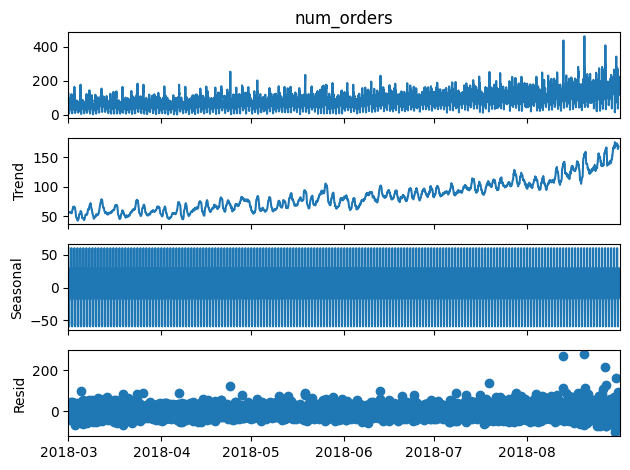

Tendencia, estacionalidad y ruido por semana


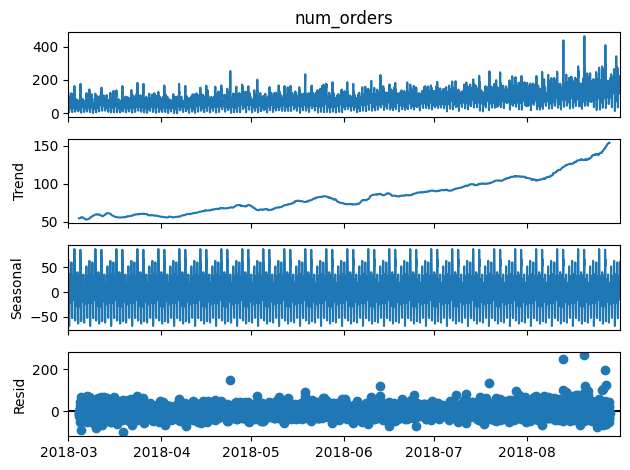

La tendencia de los datos de manera global o anual es positiva, con estacionalidad.
Tendencia, estacionalidad y ruido por día en Marzo


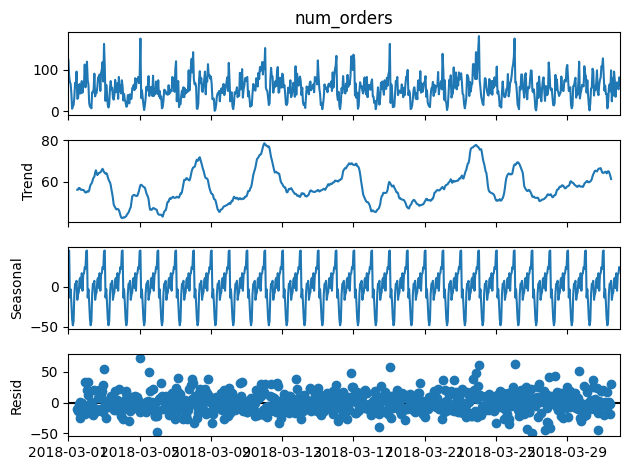

Al observar el mes observamos una tendencia ligeramente positiva, con estacionalidad.


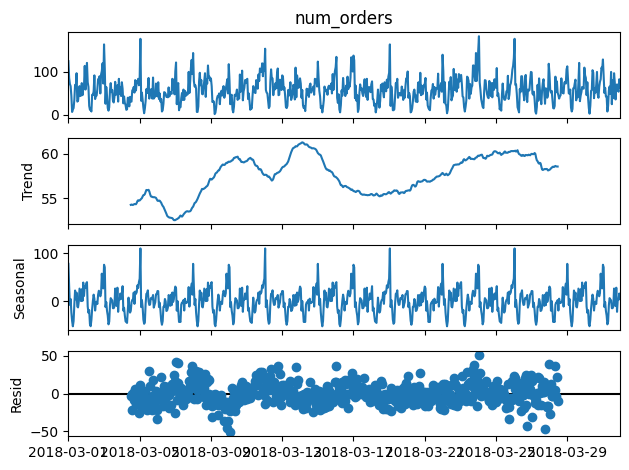

Al observar el mes por semana observamos una tendencia positiva, con estacionalidad. 
 Los datos con estacionalidad requieren de emplear un modelo estadístico tipo SARIMA.


In [5]:
#Rango
print("Hay datos desde marzo hasta agosto")

#Decomposición de estacionalidad, tendencias general. Marzo a agosto.  
resultados_dia = seasonal_decompose(datos_hora["num_orders"], model="additive", period=24)
resultados_semana = seasonal_decompose(datos_hora["num_orders"], model="additive", period=168)


print("Tendencia, estacionalidad y ruido por día")
resultados_dia.plot()
plt.show()

print("Tendencia, estacionalidad y ruido por semana")
resultados_semana.plot()
plt.show()

print("La tendencia de los datos de manera global o anual es positiva, con estacionalidad.")

#Si quisieramos observar nadamas un mes
datos_marzo = datos_hora["2018-03":"2018-03-31"]
resultados_mes_día = seasonal_decompose(datos_marzo["num_orders"], model="additive", period=24)
print("Tendencia, estacionalidad y ruido por día en Marzo")
resultados_mes_día.plot()
plt.show()
print("Al observar el mes observamos una tendencia ligeramente positiva, con estacionalidad.")

resultados_mes_semana = seasonal_decompose(datos_marzo["num_orders"], model="additive", period=168)
resultados_mes_semana.plot()
plt.show()
print("Al observar el mes por semana observamos una tendencia positiva, con estacionalidad. \n Los datos con estacionalidad requieren de emplear un modelo estadístico tipo SARIMA.")

<Figure size 1200x400 with 0 Axes>

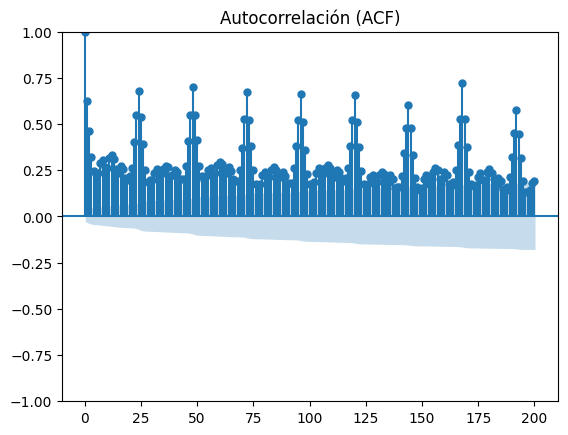

<Figure size 1200x400 with 0 Axes>

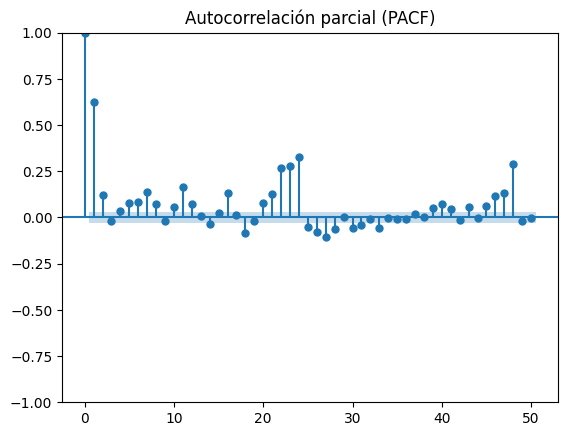

ACF demuestra decrecimiento lento por lo tanto D y d=1 para eliminar la estacionalidad diaria y demostrando no ser estacionario. El PACF demuestra una recaída fuerte en el lag 1 por lo tanto p=1.


In [6]:
#APCF y ACF 
plt.figure(figsize=(12,4))
plot_acf(datos_hora['num_orders'].dropna(), lags=200)
plt.title("Autocorrelación (ACF)")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(datos_hora['num_orders'].dropna(), lags=50)
plt.title("Autocorrelación parcial (PACF)")
plt.show()

print("ACF demuestra decrecimiento lento por lo tanto D y d=1 para eliminar la estacionalidad diaria y demostrando no ser estacionario. El PACF demuestra una recaída fuerte en el lag 1 por lo tanto p=1.")

## Formación

In [7]:
#Separación de los datos en prueba y entrenamiento
entrenamiento, prueba = train_test_split(datos_hora, shuffle=False, test_size=0.1)

display(entrenamiento.info())
display(prueba.info())
#útil para sarimax

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3974 entries, 2018-03-01 00:00:00 to 2018-08-13 13:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  3974 non-null   int64
dtypes: int64(1)
memory usage: 62.1 KB


None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  442 non-null    int64
dtypes: int64(1)
memory usage: 6.9 KB


None

In [8]:
#Preparación de los datos para ML de datos de series temporales. Generar características exógenas y dividir los datos. 
datos_ml = datos_hora.copy()
datos_ml["hour"] = datos_ml.index.hour
datos_ml["day_of_week"] = datos_ml.index.dayofweek
datos_ml["month"] = datos_ml.index.month

# Características de rezagos
datos_ml["lag_1"] = datos_ml["num_orders"].shift(1)
datos_ml["lag_24"] = datos_ml["num_orders"].shift(24)
datos_ml["lag_168"] = datos_ml["num_orders"].shift(168)  # valor hace 1 semana

# Target: el valor que queremos predecir (num_orders una hora después)
datos_ml["target"] = datos_ml["num_orders"].shift(-1)

# Elimina filas con NaNs generados por los lags
datos_ml = datos_ml.dropna()

#Separar los datos en características y objetivos y entrenamiento y prueba. 
features = ["hour", "day_of_week", "month", "lag_1", "lag_24", "lag_168"]
X = datos_ml[features]
y = datos_ml["target"]

# División 90% train, 10% test
split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
#Datos listos para entrenar ML. 

In [9]:
#Generar la toma del último valor como predictor de la siguiente hora. Empleable para todos los modelos 
ultima_hora = datos_hora.iloc[-1]
ultima_fila = {
    "hour": ultima_hora.name.hour,
    "day_of_week": ultima_hora.name.dayofweek,
    "month": ultima_hora.name.month,
    "lag_1": ultima_hora["num_orders"],
    "lag_24": datos["num_orders"].iloc[-24],
    "lag_168": datos["num_orders"].iloc[-168],
}

X_1h = pd.DataFrame([ultima_fila])

## Prueba

In [10]:
#Método estadístico manual: Predicción por SARIMA
modelo = SARIMAX(entrenamiento["num_orders"], order=(1, 1, 0),
        seasonal_order= (1,1,0,24),
        enforce_stationarity=False, 
        enforce_invertibility=False)

resultado = modelo.fit()
print(resultado.summary())

#Predicción de última hora y métrica del modelo: RECM 

pred_sig_hora = resultado.forecast(steps = 1)
print(f"Predicción para la siguiente hora: {pred_sig_hora.values[0]:.2f}")
# Cálculo del RECM
pred_prueba = resultado.predict(start=prueba.index[0], end=prueba.index[-1]) #Predicción de los valores de prueba
rmse = np.sqrt(mean_squared_error(prueba['num_orders'], pred_prueba))
print(f"RECM (RMSE) del modelo SARIMAX en el test set: {rmse:.2f}")
print("RECM muy elevado valor de 161 pedidos de variación cuando el objetivo es 48.")

                                     SARIMAX Results                                      
Dep. Variable:                         num_orders   No. Observations:                 3974
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 24)   Log Likelihood              -18863.790
Date:                            Sun, 08 Jun 2025   AIC                          37733.581
Time:                                    00:15:24   BIC                          37752.405
Sample:                                03-01-2018   HQIC                         37740.260
                                     - 08-13-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4777      0.010    -48.132      0.000      -0.497      -0.458
ar.S.L24      -0.5122      0.013   

In [11]:
#Método de regresión lineal
modelo_lr = LinearRegression()
modelo_lr.fit(X_train, y_train)
pred_lr = modelo_lr.predict(X_test)
rmse_lr = mean_squared_error(y_test, pred_lr)
print(f"RECM del modelo de regresión lineal {rmse_lr:.2f}")

RECM del modelo de regresión lineal 2861.32


In [12]:
#Método RandomForest
modelo_rf = RandomForestRegressor(random_state=54321)

#Hiperparámetros? 
param_grid_rf = {
    "n_estimators": [100, 200], 
    "max_depth": [5, 10, None], 
    "min_samples_split": [2, 5], 
    "min_samples_leaf":[1,2]
}

grid_rf = GridSearchCV(estimator=modelo_rf, 
                       param_grid=param_grid_rf, 
                       cv=2, 
                       scoring="neg_root_mean_squared_error", 
                       n_jobs=-1)

grid_rf.fit(X_train, y_train)
mejor_rf = grid_rf.best_estimator_
print(f"Mejores parámetros RF:{grid_rf.best_params_}") 

Mejores parámetros RF:{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [16]:
#RECM de RandomForest
pred = mejor_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred))
print(f"RECM de rf: {rmse_rf:.2f}. \nSe puede buscar cambiar hiperparámetros hasta empujar abajo de 48. Sin embargo otro modelo lo logró.")

#Predicción siguiente hora.
pred_rf_1h = mejor_rf.predict(X_1h)[0]


print(f"Predicción siguiente hora (RF): {pred_rf_1h:.2f} órdenes")


RECM de rf: 49.02. 
Se puede buscar cambiar hiperparámetros hasta empujar abajo de 48. Sin embargo otro modelo lo logró.
Predicción siguiente hora (RF): 115.33 órdenes


In [13]:
#LightGBM

#Búsqueda de mejores hiperparámetros
param_grid_lgb = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.1]
}

lgb_model = lgb.LGBMRegressor(random_state=42)

grid_lgb = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid_lgb,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_lgb.fit(X_train, y_train)
mejor_lgb = grid_lgb.best_estimator_
print(f"Mejores parámetros LightGBM: {grid_lgb.best_params_}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 3822, number of used features: 6
[LightGBM] [Info] Start training from score 79.545003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [17]:
#RECM
y_pred_lgb = mejor_lgb.predict(X_test)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print(f"RECM de lgb: {rmse_lgb:.2f}")
#Predicción siguiente hora
pred_lgb_1h = mejor_lgb.predict(X_1h)[0]
print(f"Predicción siguiente hora (LGBM): {pred_lgb_1h:.2f} órdenes")

RECM de lgb: 47.09
Predicción siguiente hora (LGBM): 119.87 órdenes


Conclusiones

Se entrenaron modelos supervisados de predicción de series temporales. Lgb logró mantenerse dentro del umbral de aceptación de 48 órdenes de variación máxima (RECM 48) y predijo que el número de órdenes de taxi a ser realizadas en la siguiente hora es de 120 órdenes. 

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48